In [18]:
import os
import random
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. CONFIGURATION ---
TRAIN_SIZE_PER_CLASS = 70  
TEST_SIZE_PER_CLASS = 30  
FIXED_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

base_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA"

protocol_path = os.path.join(base_path, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
audio_dir = os.path.join(base_path, "ASVspoof2019_LA_train/flac")

Running on: cuda


In [19]:
# --- 3. DATA PREPARATION ---
print("Parsing protocol...")
df = pd.read_csv(protocol_path, sep=" ", header=None, names=["speaker", "filename", "system", "null", "label"])
df['path'] = df['filename'].apply(lambda x: os.path.join(audio_dir, x + ".flac"))

real_paths = df[df['label'] == 'bonafide']['path'].tolist()
fake_paths = df[df['label'] == 'spoof']['path'].tolist()

# Ensure we have enough data
total_needed = TRAIN_SIZE_PER_CLASS + TEST_SIZE_PER_CLASS
if len(real_paths) < total_needed or len(fake_paths) < total_needed:
    raise ValueError("Not enough data points for the requested split.")

# Random Selection
subset_real = random.sample(real_paths, total_needed)
subset_fake = random.sample(fake_paths, total_needed)

# Slicing for Train/Test
train_paths = subset_real[:TRAIN_SIZE_PER_CLASS] + subset_fake[:TRAIN_SIZE_PER_CLASS]
train_labels = [0] * TRAIN_SIZE_PER_CLASS + [1] * TRAIN_SIZE_PER_CLASS # 0=Real, 1=Fake

test_paths = subset_real[TRAIN_SIZE_PER_CLASS:] + subset_fake[TRAIN_SIZE_PER_CLASS:]
test_labels = [0] * TEST_SIZE_PER_CLASS + [1] * TEST_SIZE_PER_CLASS

print(f"   Data Prepared:")
print(f"   Training: {len(train_paths)} samples ({TRAIN_SIZE_PER_CLASS} Real / {TRAIN_SIZE_PER_CLASS} Fake)")
print(f"   Testing:  {len(test_paths)} samples ({TEST_SIZE_PER_CLASS} Real / {TEST_SIZE_PER_CLASS} Fake)")


Parsing protocol...
   Data Prepared:
   Training: 140 samples (70 Real / 70 Fake)
   Testing:  60 samples (30 Real / 30 Fake)


In [25]:
# --- 4. SPECTROGRAM DATASET ---
class DeepfakeSpectrogramDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        
        try:
            y, sr = librosa.load(path, sr=16000)
        except:
            y = np.zeros(16000)
            sr = 16000
            
        # Create Mel Spectrogram (Image)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=2048, hop_length=512)
        S_dB = librosa.power_to_db(S, ref=np.max)
        S_dB = (S_dB + 80) / 80 # Normalize
        
        # Fixed Width Pad/Crop
        if S_dB.shape[1] > FIXED_LENGTH:
            S_dB = S_dB[:, :FIXED_LENGTH]
        else:
            pad_width = FIXED_LENGTH - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0, 0), (0, pad_width)), mode='constant')
            
        return torch.tensor(S_dB, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)

train_loader = DataLoader(DeepfakeSpectrogramDataset(train_paths, train_labels), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(DeepfakeSpectrogramDataset(test_paths, test_labels), batch_size=BATCH_SIZE, shuffle=False)

# --- 5. CNN MODEL ---
class ArtifactHunterCNN(nn.Module):
    def __init__(self):
        super(ArtifactHunterCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = ArtifactHunterCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [26]:
# --- 6. TRAINING ---
print("\n Starting Training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {100*correct/total:.1f}%")


 Starting Training...
Epoch 1/20 | Loss: 1.6017 | Train Acc: 64.3%
Epoch 2/20 | Loss: 0.9949 | Train Acc: 68.6%
Epoch 3/20 | Loss: 0.6418 | Train Acc: 75.0%
Epoch 4/20 | Loss: 0.3730 | Train Acc: 85.0%
Epoch 5/20 | Loss: 0.4594 | Train Acc: 74.3%
Epoch 6/20 | Loss: 0.3448 | Train Acc: 84.3%
Epoch 7/20 | Loss: 0.3008 | Train Acc: 87.9%
Epoch 8/20 | Loss: 0.2525 | Train Acc: 88.6%
Epoch 9/20 | Loss: 0.2181 | Train Acc: 92.1%
Epoch 10/20 | Loss: 0.2278 | Train Acc: 90.7%
Epoch 11/20 | Loss: 0.2031 | Train Acc: 90.0%
Epoch 12/20 | Loss: 0.1747 | Train Acc: 93.6%
Epoch 13/20 | Loss: 0.1426 | Train Acc: 94.3%
Epoch 14/20 | Loss: 0.0780 | Train Acc: 97.9%
Epoch 15/20 | Loss: 0.0614 | Train Acc: 99.3%
Epoch 16/20 | Loss: 0.0674 | Train Acc: 97.1%
Epoch 17/20 | Loss: 0.0492 | Train Acc: 97.9%
Epoch 18/20 | Loss: 0.0383 | Train Acc: 98.6%
Epoch 19/20 | Loss: 0.0299 | Train Acc: 99.3%
Epoch 20/20 | Loss: 0.0121 | Train Acc: 100.0%



 Evaluating on Test Data...
Final Test Accuracy: 88.3%


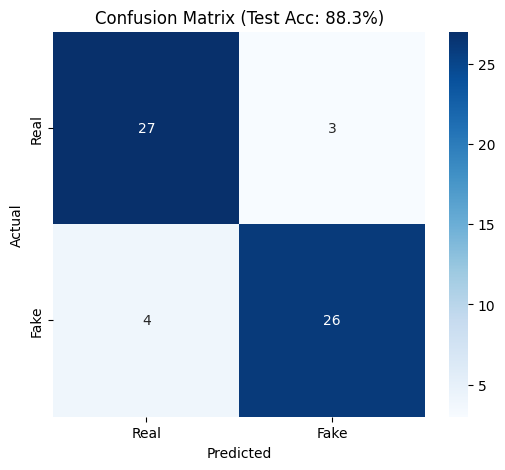


Detailed Report:
              precision    recall  f1-score   support

        Real       0.87      0.90      0.89        30
        Fake       0.90      0.87      0.88        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [27]:
# --- 7. EVALUATION & CONFUSION MATRIX ---
print("\n Evaluating on Test Data...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Accuracy
correct = sum([1 for x, y in zip(all_preds, all_labels) if x == y])
accuracy = 100 * correct / len(all_labels)
print(f"Final Test Accuracy: {accuracy:.1f}%")

# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Test Acc: {accuracy:.1f}%)')
plt.show()
plt.savefig

# Print Report
print("\nDetailed Report:")
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))